# Decomposition

In this Notebook I tested different possibilities of differencing and decomposition with the purpose of making sure that our data is stationary. This is because we found out in our research that many models work better for stationary data and because the data needs to be stationary to find patterns between different data sources. The tests need to be done for all the feature we use in our final model.

Good website: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, mean_absolute_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
import scipy.stats as stats
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
montel = pd.read_csv('../data/montel/data.csv')

In [3]:
df = montel.set_index('Time')
df.index = pd.to_datetime(df.index)

# Original data

Text(0.5, 1.0, 'EEX Day-Ahead Market')

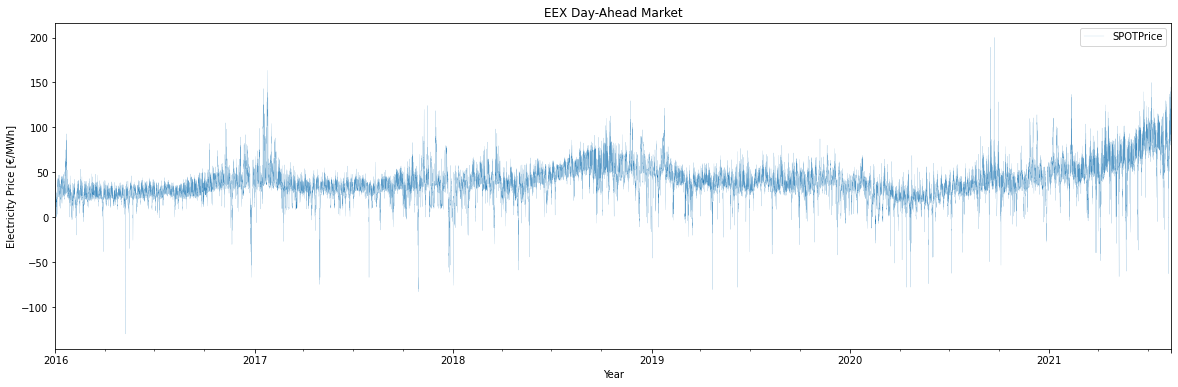

In [4]:
ax = df.plot(linewidth=0.1, figsize = (20, 6))
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Price [€/MWh]')
ax.set_title('EEX Day-Ahead Market')

# Differenced data (subtract (t) - (t-1)

In [5]:
# automatic differencing (t) - (t-1)
differenced = df.diff(periods = 1)

In [6]:
diff = df.diff(12)

Text(0.5, 1.0, 'EEX Day-Ahead Market')

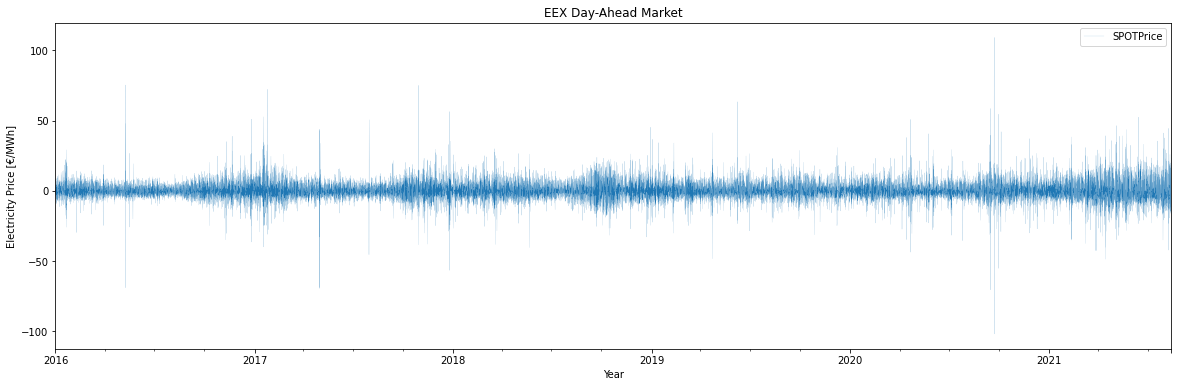

In [7]:
ax = differenced.plot(linewidth=0.1, figsize = (20, 6))
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Price [€/MWh]')
ax.set_title('EEX Day-Ahead Market')

/home/jakob/Documents/group03/venv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


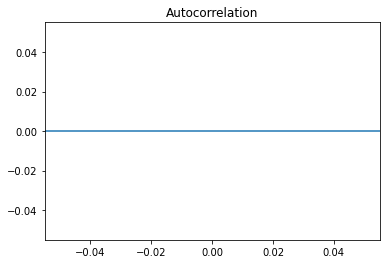

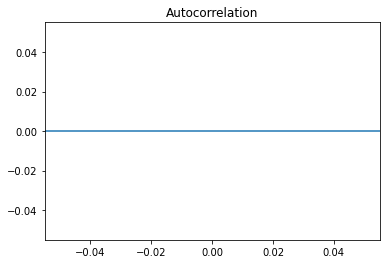

In [8]:
plot_acf(diff)

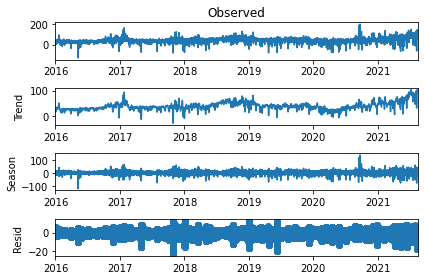

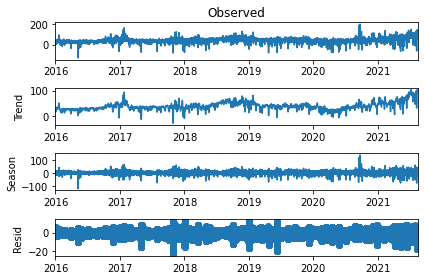

In [9]:
stl = STL(df, seasonal=3, period = 24)
res = stl.fit()
res.plot()

In [10]:
# plot decomposed data
def add_stl_plot(fig, res, legend):
    """Add 3 plots from a second STL fit"""
    axs = fig.get_axes()
    comps = ['trend', 'seasonal', 'resid']
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == 'resid':
            ax.plot(series, marker='o', linestyle='none')
        else:
            ax.plot(series)
            if comp == 'trend':
                ax.legend(legend, frameon=False)

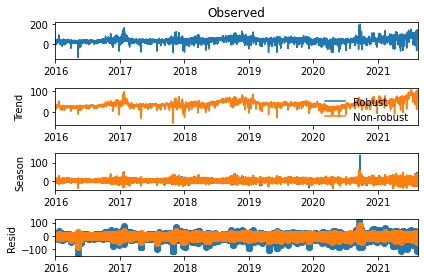

In [11]:
stl = STL(df, period=24, robust=True)
res_robust = stl.fit()
fig = res_robust.plot()
res_non_robust = STL(df, period=24, robust=False).fit()
add_stl_plot(fig, res_non_robust, ['Robust','Non-robust'])

# Stationarity

In [12]:
# stationarity test with a rolling window approach 
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=24*7).mean()
    rolstd = timeseries.rolling(window=24*7).std()

    #Plot rolling statistics:
    plt.figure(figsize = (20, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, regression = 'ctt' ,autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

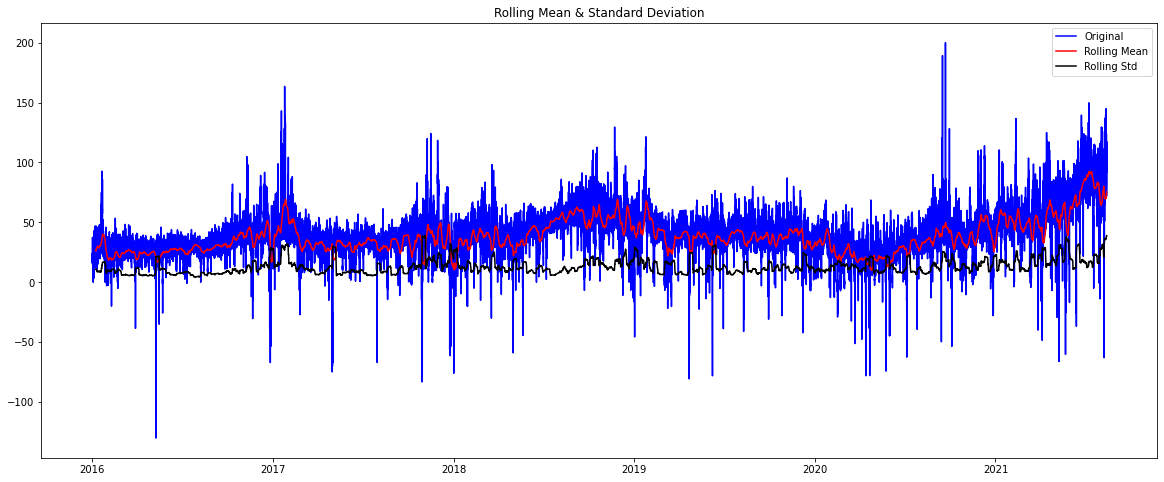

Results of Dickey-Fuller Test:
Test Statistic                -1.468405e+01
p-value                        1.481679e-23
#Lags Used                     5.700000e+01
Number of Observations Used    4.919000e+04
Critical Value (1%)           -4.371366e+00
Critical Value (5%)           -3.832510e+00
Critical Value (10%)          -3.553334e+00
dtype: float64


In [13]:
test_stationarity(df)
# staionarity is fulfilled as the test statistic is 
#beneath the critical values and the p vaue is less than 0.05

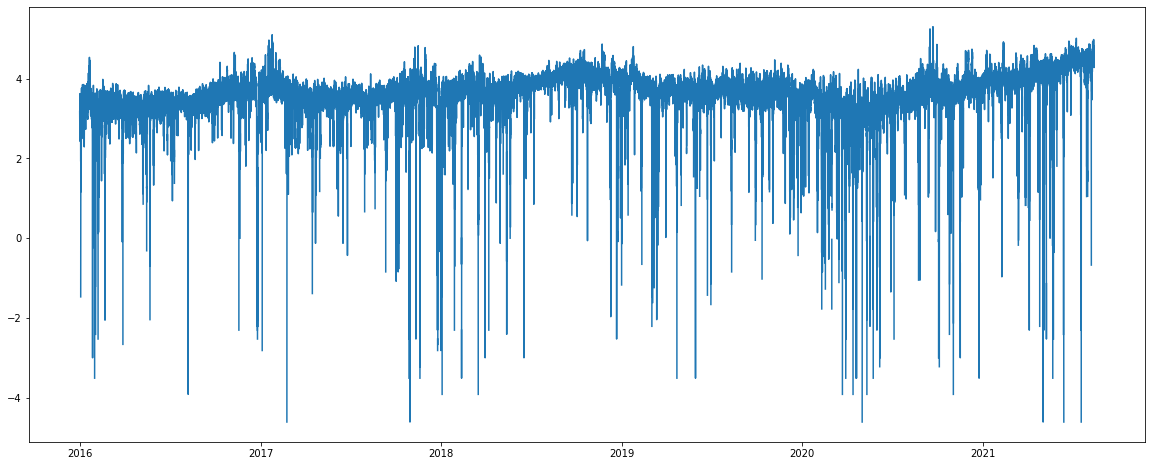

In [14]:
ts_log = np.log(df)
plt.figure(figsize = (20, 8))
plt.plot(ts_log)

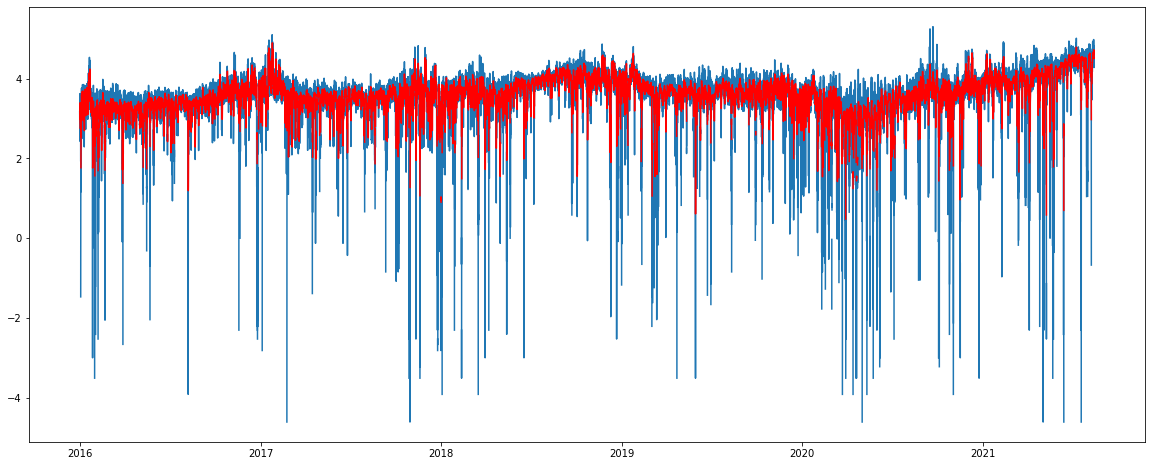

In [15]:
moving_avg = ts_log.rolling(window = 12).mean()
plt.figure(figsize = (20, 8))
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

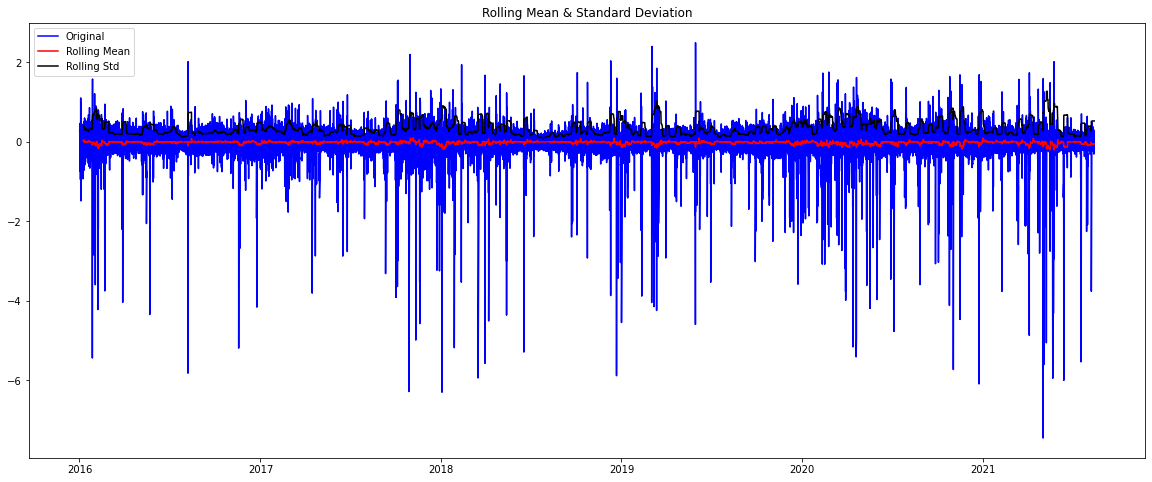

Results of Dickey-Fuller Test:
Test Statistic                   -33.720075
p-value                            0.000000
#Lags Used                        55.000000
Number of Observations Used    46531.000000
Critical Value (1%)               -4.371379
Critical Value (5%)               -3.832517
Critical Value (10%)              -3.553339
dtype: float64


In [16]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

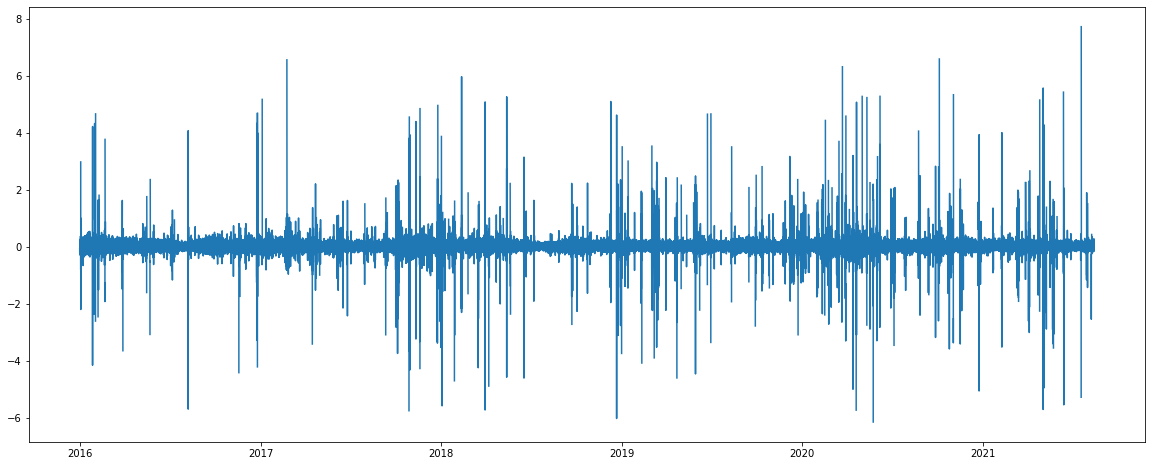

In [17]:
plt.figure(figsize = (20, 8))
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

In [18]:
ts_log_diff.dropna(inplace=True)
print(ts_log_diff)
ts_log_diff.isna().sum()
ts_log_diff = ts_log_diff.fillna(method='ffill') 
print(ts_log_diff.isna().sum())

                     SPOTPrice
Time                          
2016-01-01 01:00:00  -0.063589
2016-01-01 02:00:00  -0.083809
2016-01-01 03:00:00  -0.202832
2016-01-01 04:00:00   0.035071
2016-01-01 05:00:00  -0.022656
...                        ...
2021-08-13 19:00:00   0.113165
2021-08-13 20:00:00  -0.015440
2021-08-13 21:00:00   0.000778
2021-08-13 22:00:00  -0.079618
2021-08-13 23:00:00  -0.148136

[48172 rows x 1 columns]
SPOTPrice    0
dtype: int64


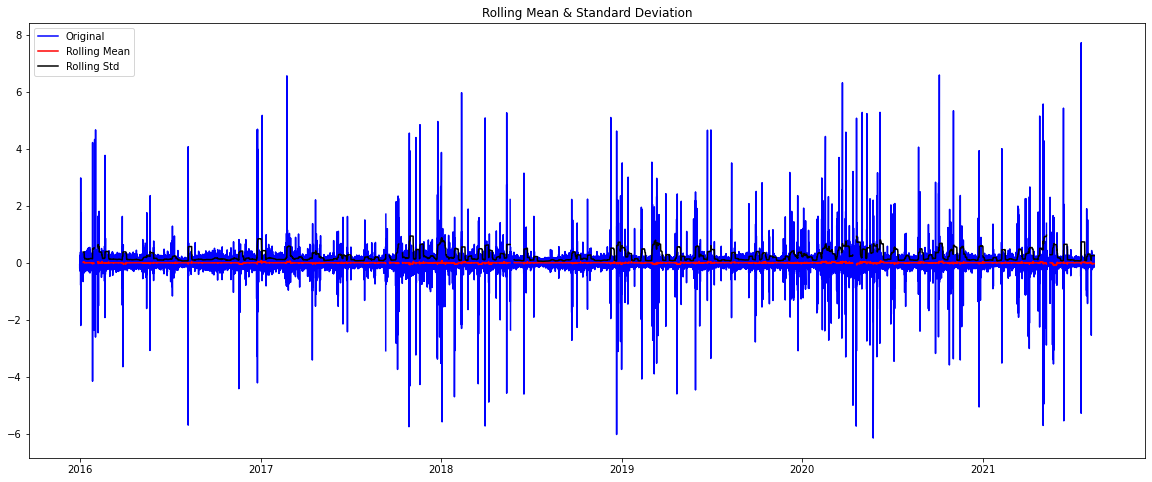

Results of Dickey-Fuller Test:


MissingDataError: exog contains inf or nans

In [19]:
test_stationarity(ts_log_diff)